In [9]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys 
import h5py
from mpl_toolkits.mplot3d import Axes3D

sys.path.append("/home/amisery/SemesterProject")
from data.data_utils import *

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
data_path = "/scratch2/sfgd/sparse_data_genie_fhc_numu_hittag/"
N_files = len(os.listdir(data_path))

Let's check the content of the event files

In [12]:
f = np.load(data_path + 'event0.npz')
keys = list(f.keys())
print(keys)

['x', 'c', 'y', 'verPos']


In [13]:
len(f["y"])

238

In [14]:
for k in keys :
    print(f[k].shape)
print(f["verPos"])

(238, 12)
(238, 3)
(238, 1)
(3,)
[ -253.93285902    68.95139531 -1544.77885975]


Let's also check the created h5 file

In [15]:
hf = h5py.File("/home/amisery/out.h5", "r")

In [16]:
print(hf["event_hits_index"][N_files-1])
print(hf["event_hits_index"][4:None])
len(hf["coords"])-hf["event_hits_index"][-1]

55822319
[     741      823      906 ... 55821973 55822222 55822319]


21

In [17]:
def plot_stats(evt):
        fig, axs = plt.subplots(4,3, figsize = (10,10))
        i=0
        names = ["HitTime", "HitCharge", "HitMPPCXY", "HitMPPCXZ", "HitMPPCYZ","HitNumberXY", "HitNumberXZ", "HitNumberYZ", "HitAdjacent", "HitDiagonal", "HitCorner", "HitDistance2Vertex"]
        for idx,ax in enumerate(fig.axes):
                f_split = [evt["x"][(evt["y"]==j).squeeze(1),i] for j in range(1,4)]
                ax.hist(f_split, histtype= "barstacked", bins = 25, color = ["yellow", "red", "blue"])
                ax.set_title(names[i])
                i+=1
        fig.legend(["multi", "single", "other"])
        plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9,
                        wspace=0.4, 
                        hspace=0.4)
        plt.show()

        plt.clf()

        fig = plt.figure(figsize=(10,10))
        i = 1
        f_split = [evt["x"][(evt["y"]==j).squeeze(1),i] for j in range(1,4)]
        plt.hist(f_split, histtype= "barstacked", bins = 50, color = ["yellow", "red", "blue"], range = (0,100))
        plt.title(names[i])
        plt.show()


In [18]:
def display_3D(evt):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    c_list = ["yellow", "red", "blue"]
    labels = ["multi", "single", "other"]
    for i in range(1,4):
        cat_coords = evt["c"][(evt["y"]==i).squeeze(1),:]
        ax.scatter(cat_coords[:,0], cat_coords[:,1], cat_coords[:,2], color = c_list[i-1], edgecolor = "black", alpha = 1, label = labels[i-1])
    ax.legend()
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

In [19]:
def display_3D_h5(evt_id):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    c_list = ["yellow", "red", "blue"]
    labels = ["multi", "single", "other"]
    h_start, h_stop = hf["event_hits_index"][evt_id], hf["event_hits_index"][evt_id+1]

    coords = hf["coords"][h_start:h_stop]
    vals = hf["labels"][h_start:h_stop]

    for i in range(1,4):
        cat_coords =coords[(vals==i).squeeze(1),:]
        ax.scatter(cat_coords[:,0], cat_coords[:,1], cat_coords[:,2], color = c_list[i-1], edgecolor = "black", alpha = 1, label = labels[i-1])
    ax.legend()
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")


In [20]:
def show_event(evt_id = None, plot_stat = False, h5 = False):
    #show a random event from a dataset
    if evt_id == None :
        evt_id = np.random.randint(1,N_files)
    evt = np.load(data_path + "event%d.npz"%evt_id)
    if h5:
        display_3D_h5(evt_id)
    else :
        display_3D(evt)
    plt.title("Event #%d, %d hits"%(evt_id, len(evt["c"])), fontsize = 16)
    plt.show()
    plt.clf()
    if plot_stat:
        plot_stats(evt)

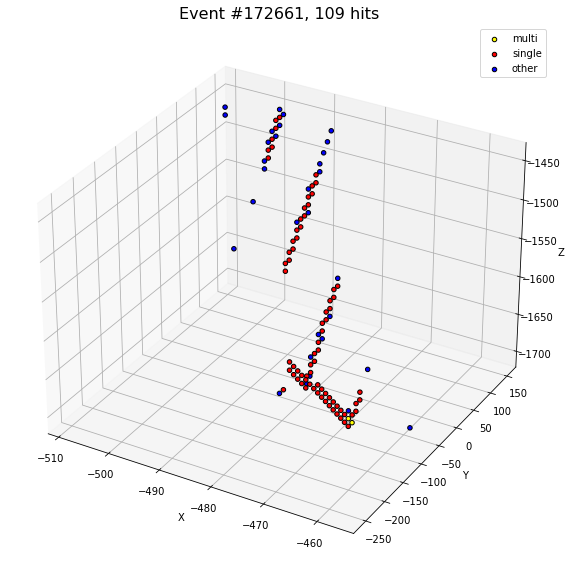

<Figure size 432x288 with 0 Axes>

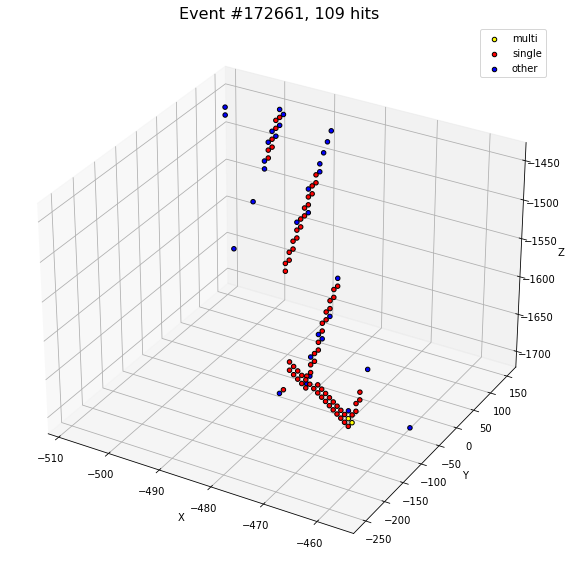

<Figure size 432x288 with 0 Axes>

In [21]:
evt_id = np.random.randint(1,N_files)
show_event(evt_id, h5=True)
show_event(evt_id)

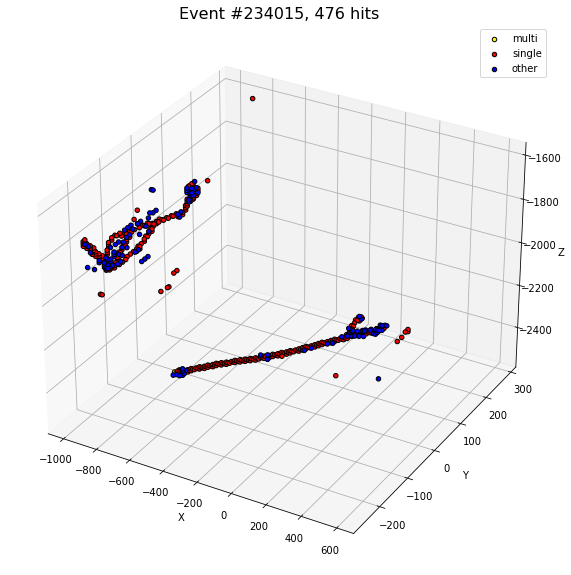

<Figure size 432x288 with 0 Axes>

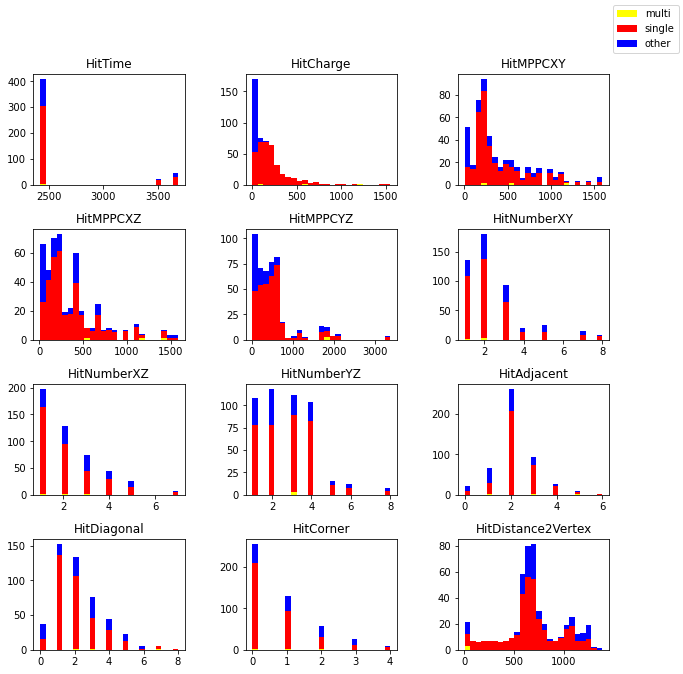

<Figure size 432x288 with 0 Axes>

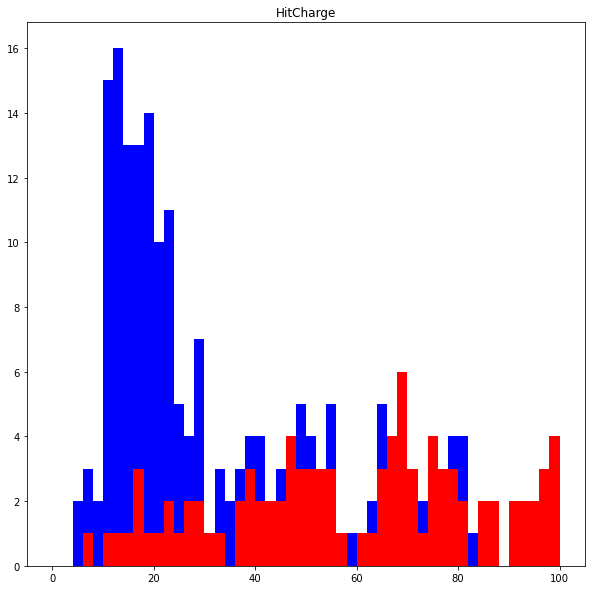

In [22]:
show_event(234015,plot_stat = True)

Global Dataset statistics

In [23]:
# lengths = []
# tot_charge = []
# max_dist_to_vertex = []
# charge_deposit = np.array([])
# for i in range(N_files):
#     evt = np.load(data_path + "event%d.npz"%i)
#     lengths.append(len(evt["x"]))
#     tot_charge.append(np.sum(evt["x"][:,1]))
#     max_dist_to_vertex.append(np.max(evt["c"].astype("float32")-evt["verPos"].astype("float32")))
#     charge_deposit = np.concatenate((charge_deposit,evt["x"][:,1]))
#     if i > 10000:
#         break
# plt.hist(lengths, bins = 50)


Speed comparison with the h5 dataset

(array([1.697e+03, 2.428e+03, 2.129e+03, 1.430e+03, 7.660e+02, 4.790e+02,
        2.680e+02, 1.690e+02, 1.190e+02, 9.000e+01, 7.100e+01, 5.400e+01,
        4.200e+01, 4.300e+01, 3.300e+01, 3.600e+01, 2.200e+01, 8.000e+00,
        1.600e+01, 1.400e+01, 9.000e+00, 1.100e+01, 8.000e+00, 6.000e+00,
        5.000e+00, 1.100e+01, 0.000e+00, 3.000e+00, 5.000e+00, 3.000e+00,
        4.000e+00, 4.000e+00, 4.000e+00, 1.000e+00, 4.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([   5.  ,   59.08,  113.16,  167.24,  221.32,  275.4 ,  329.48,
         383.56,  437.64,  491.72,  545.8 ,  599.88,  653.96,  708.04,
         762.12,  816.2 ,  870.28,  924.36,  978.44, 1032.52, 1086.6 ,
        1140.68, 1194.76, 1248.84, 1302.92, 1357.  , 1411.08, 1465.16,
        1519.24, 1573.32, 1627.4 , 1681.48, 1735.56, 1789.64, 1843.72,
        1897.8 , 1951

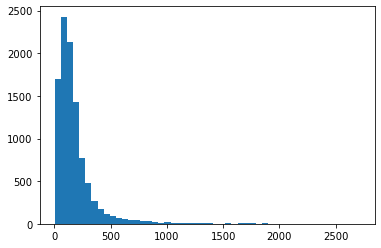

In [33]:
lengths = []
tot_charge = []
max_dist_to_vertex = []
noise, single, multi = 0, 0, 0
charge_deposit = np.array([])
for i in range(N_files):
    h_start, h_stop = hf["event_hits_index"][i], hf["event_hits_index"][i+1]

    coords = hf["coords"][h_start:h_stop]
    charge = hf["charge"][h_start:h_stop]
    vals = hf["labels"][h_start:h_stop]
    noise += np.sum(vals == 3)
    single += np.sum(vals==2)
    multi += np.sum(vals==1)
    verpos = hf["verPos"][i]
    lengths.append(h_stop-h_start)
    tot_charge.append(np.sum(charge))

    max_dist_to_vertex.append(np.max(coords-verpos))
    # charge_deposit = np.concatenate((charge_deposit,evt["x"][:,1]))
    if i > 10000:
        break
plt.hist(lengths, bins = 50)


In [41]:
print("noise : %.3f ; single particule : %.3f ; multi : %.3f"%(noise/np.sum(lengths), single/np.sum(lengths), multi/np.sum(lengths)))

noise : 0.228 ; single particule : 0.752 ; multi : 0.020


In [44]:
single/noise, single/single, single/multi

(3.297880389081245, 1.0, 37.24093271297581)

Text(0.5, 0, '$E_{tot} [MeV]$')

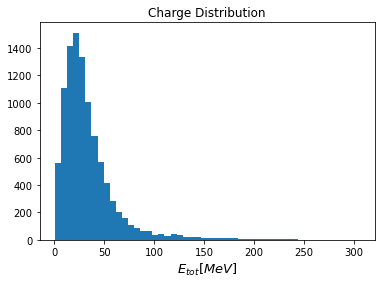

In [ ]:
plt.hist(np.array(tot_charge)/1000, bins = 50)
plt.title("Charge Distribution")
plt.xlabel(r"$E_{tot} [MeV]$", fontsize = 13)

Text(0.5, 0, '$E [eV]$')

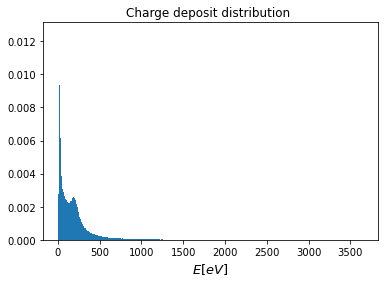

In [ ]:
plt.hist(charge_deposit, bins = 500, density = True)

plt.title("Charge deposit distribution ")
plt.xlabel(r"$E [eV]$", fontsize = 13)

(array([ 18., 342., 359., 401., 491., 482., 489., 522., 481., 503., 507.,
        420., 407., 385., 349., 313., 237., 255., 270., 217., 193., 187.,
        180., 173., 164., 149., 127., 145., 136., 134., 103., 111.,  91.,
        105.,  98.,  68.,  68.,  77.,  53.,  48.,  57.,  50.,  16.,   3.,
          0.,   7.,   4.,   3.,   2.,   2.]),
 array([ -23.36319  ,   15.6632805,   54.68975  ,   93.716225 ,
         132.74269  ,  171.76917  ,  210.79564  ,  249.8221   ,
         288.84857  ,  327.87503  ,  366.90152  ,  405.92798  ,
         444.95447  ,  483.98093  ,  523.0074   ,  562.0339   ,
         601.06036  ,  640.0868   ,  679.1133   ,  718.1398   ,
         757.1662   ,  796.1927   ,  835.2192   ,  874.2456   ,
         913.2721   ,  952.2986   ,  991.325    , 1030.3516   ,
        1069.3779   , 1108.4044   , 1147.4309   , 1186.4574   ,
        1225.4839   , 1264.5104   , 1303.5367   , 1342.5632   ,
        1381.5897   , 1420.6162   , 1459.6427   , 1498.6692   ,
        1537.6957 

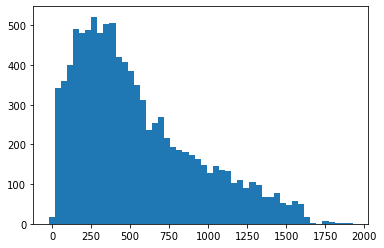

In [ ]:
plt.hist(max_dist_to_vertex, bins = 50)

In [ ]:
np.mean(max_dist_to_vertex)

542.14264

(array([8.35600e+03, 2.42800e+03, 1.74100e+03, 1.47300e+03, 1.38800e+03,
        1.23700e+03, 1.22900e+03, 1.27300e+03, 1.34500e+03, 8.75900e+03,
        2.48000e+04, 3.14590e+04, 3.75340e+04, 4.17830e+04, 4.42620e+04,
        4.39200e+04, 4.20010e+04, 4.01720e+04, 3.84640e+04, 3.67420e+04,
        3.59770e+04, 3.52860e+04, 3.56860e+04, 3.63720e+04, 3.77950e+04,
        3.95370e+04, 4.28710e+04, 4.53100e+04, 4.85690e+04, 5.21710e+04,
        5.59680e+04, 6.10890e+04, 6.83940e+04, 8.16590e+04, 9.80910e+04,
        1.08963e+05, 1.02517e+05, 8.17960e+04, 6.29190e+04, 4.97010e+04,
        4.07510e+04, 3.43280e+04, 2.84160e+04, 2.32520e+04, 1.96900e+04,
        1.62830e+04, 1.37490e+04, 1.17600e+04, 9.74700e+03, 8.18600e+03,
        6.56800e+03, 5.57600e+03, 4.43200e+03, 3.32600e+03, 2.10500e+03,
        8.22000e+02, 2.78000e+02, 1.44000e+02, 3.60000e+01, 1.20000e+01]),
 array([-1.02700244, -0.99746407, -0.9679257 , -0.93838734, -0.90884897,
        -0.8793106 , -0.84977223, -0.82023387, -0

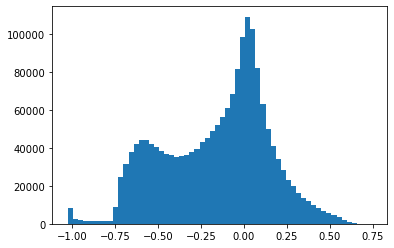

In [ ]:
plt.hist(np.log(charge_deposit/185)/4, bins = 60)

In [ ]:
np.mean(charge_deposit)

185.02361565124374

Testing a simple pytorch dataset from directly loading the npz files

In [ ]:
import torch
from torch.utils.data import Sampler, RandomSampler, Dataset, BatchSampler

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
pred = torch.randn((32,1))
target = torch.randn((32,1))
loss_fn(pred,target)

tensor(-0.)

Experimenting with self attention and other layers

In [ ]:
seq_length = 4
emb_dim = 8

X = torch.randn(emb_dim, seq_length)

W = torch.randn(emb_dim, emb_dim)
b = torch.randn(emb_dim, seq_length)
perm = torch.randperm(seq_length)

X_perm = X[:,perm]
print(perm)
print(torch.matmul(W,X) +b - (torch.matmul(W, X_perm)+b)[:,perm])
print(b)

tensor([3, 2, 1, 0])
tensor([[-0.0362,  1.6363, -1.6363,  0.0362],
        [ 1.7872, -2.5278,  2.5278, -1.7872],
        [-0.3105, -2.7059,  2.7059,  0.3105],
        [-0.8059, -0.5552,  0.5552,  0.8059],
        [-0.3339, -2.2202,  2.2202,  0.3339],
        [-0.2510, -0.7453,  0.7453,  0.2510],
        [ 1.6313, -2.5315,  2.5315, -1.6313],
        [-0.7170,  0.5304, -0.5304,  0.7170]])
tensor([[-0.0722,  0.4564, -1.1798, -0.0360],
        [ 0.6087, -0.3553,  2.1726, -1.1785],
        [ 1.0957, -1.7108,  0.9952,  1.4061],
        [-0.3877, -0.5714, -0.0162,  0.4182],
        [ 0.7406, -1.2290,  0.9912,  1.0746],
        [-0.0715, -0.0089,  0.7364,  0.1795],
        [ 0.0950, -1.6903,  0.8412, -1.5363],
        [-0.1963, -0.9064, -1.4367,  0.5207]])


In [ ]:
lin = torch.nn.Linear(emb_dim,emb_dim, bias = False)
print(torch.transpose(X,0,1))
print(torch.transpose(X_perm,0,1))
print(lin(torch.transpose(X,0,1)) - lin(torch.transpose(X_perm,0,1)))


tensor([[-0.6727,  0.5953, -0.5806,  0.3077,  1.3631, -0.3038,  2.8428, -0.5966],
        [ 0.8784, -2.8864,  0.6290, -0.5740, -0.9841,  1.0703,  0.6113, -0.2277],
        [-1.0126, -1.7998,  1.0307, -0.0140,  0.8614,  0.6814,  0.0911,  0.4820],
        [-0.5720, -1.2491, -1.0694, -0.5713,  1.3774,  1.0711, -0.9002, -0.9218]])
tensor([[-0.5720, -1.2491, -1.0694, -0.5713,  1.3774,  1.0711, -0.9002, -0.9218],
        [-1.0126, -1.7998,  1.0307, -0.0140,  0.8614,  0.6814,  0.0911,  0.4820],
        [ 0.8784, -2.8864,  0.6290, -0.5740, -0.9841,  1.0703,  0.6113, -0.2277],
        [-0.6727,  0.5953, -0.5806,  0.3077,  1.3631, -0.3038,  2.8428, -0.5966]])
tensor([[-1.1991, -0.5103, -1.0983, -1.1158,  1.2414, -0.5109,  0.1474,  0.4541],
        [-0.4554,  0.7865,  0.1553, -0.1163,  0.6590,  1.2867, -0.1006,  0.2968],
        [ 0.4554, -0.7865, -0.1553,  0.1163, -0.6590, -1.2867,  0.1006, -0.2968],
        [ 1.1991,  0.5103,  1.0983,  1.1158, -1.2414,  0.5109, -0.1474, -0.4541]],
       grad_f

In [ ]:
from models.transformer_encoder import EncoderLayer,Model
enc_lay = EncoderLayer(64,32,64//16, dropout = 0.01)
x = torch.ones(1,5,4)
mask = torch.ones(1,5)

model = Model(64,32,4,5,4,3)
model(x,mask)

ModuleNotFoundError: No module named 'transformer_encoder'